# 互相关运算

严格来说，卷积层是个错误的叫法，因为它所表达的运算其实是*互相关运算*（cross-correlation），而不是卷积运算。
根据 :numref:`sec_why-conv`中的描述，在卷积层中，输入张量和核张量通过(**互相关运算**)产生输出张量。


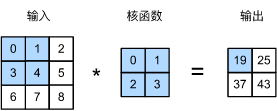

在二维互相关运算中，卷积窗口从输入张量的左上角开始，从左到右、从上到下滑动。
当卷积窗口滑动到新一个位置时，包含在该窗口中的部分张量与卷积核张量进行按元素相乘，得到的张量再求和得到一个单一的标量值，由此我们得出了这一位置的输出张量值。
在如上例子中，输出张量的四个元素由二维互相关运算得到，这个输出高度为$2$、宽度为$2$，如下所示：

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

注意，输出大小略小于输入大小。这是因为卷积核的宽度和高度大于1，
而卷积核只与图像中每个大小完全适合的位置进行互相关运算。
所以，输出大小等于输入大小$n_h \times n_w$减去卷积核大小$k_h \times k_w$，即：

$$(n_h-k_h+1) \times (n_w-k_w+1).$$

这是因为我们需要足够的空间在图像上“移动”卷积核。稍后，我们将看到如何通过在图像边界周围填充零来保证有足够的空间移动卷积核，从而保持输出大小不变。
接下来，我们在`corr2d`函数中实现如上过程，该函数接受输入张量`X`和卷积核张量`K`，并返回输出张量`Y`。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):  #@save
    """计算二维互相关运算"""
    h, w = K.shape    ##首先获取卷积核K的高度h和宽度w
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))##创建一个与输出结果尺寸相同的二维张量Y，初始化为全0。
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()##通过卷积核计算卷积结果，对于每个位置(i, j),使用切片操作提取输入张量X中与当前卷积核位置对应的子区域,然后与卷积核K进行元素级乘法并求和,得到该位置的输出值。
    return Y

 输入张量`X`和卷积核张量`K`，我们来[**验证上述二维互相关运算的输出**]。
 


In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

# 卷积层

卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出。
所以，卷积层中的两个被训练的参数是卷积核权重和标量偏置。
就像我们之前随机初始化全连接层一样，在训练基于卷积层的模型时，我们也随机初始化卷积核权重。

基于上面定义的`corr2d`函数[**实现二维卷积层**]。在`__init__`构造函数中，将`weight`和`bias`声明为两个模型参数。前向传播函数调用`corr2d`函数并添加偏置。

In [4]:
class Conv2D(nn.Module):##Conv2D类继承自nn.Module,这是PyTorch中定义神经网络层的基类。
    def __init__(self, kernel_size):
        super().__init__()
        ##使用nn.Parameter创建了两个可学习的参数:
        self.weight = nn.Parameter(torch.rand(kernel_size))##self.weight: 即卷积核,初始化为随机值。
        self.bias = nn.Parameter(torch.zeros(1))##self.bias: 偏置项,初始化为全0。

    def forward(self, x):##这个方法定义了前向传播过程。
        return corr2d(x, self.weight) + self.bias

高度和宽度分别为$h$和$w$的卷积核可以被称为$h \times w$卷积或$h \times w$卷积核。
我们也将带有$h \times w$卷积核的卷积层称为$h \times w$卷积层。

## 图像中目标的边缘检测



如下是[**卷积层的一个简单应用：**]通过找到像素变化的位置，来(**检测图像中不同颜色的边缘**)。
首先，我们构造一个$6\times 8$像素的黑白图像。中间四列为黑色（$0$），其余像素为白色（$1$）。

In [13]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来，我们构造一个高度为$1$、宽度为$2$的卷积核`K`。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。


In [14]:
K = torch.tensor([[1.0, -1.0]])

In [15]:
K

tensor([[ 1., -1.]])

In [16]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

现在我们将输入的二维图像转置，再进行如上的互相关运算。
其输出如下，之前检测到的垂直边缘消失了。
不出所料，这个[**卷积核`K`只可以检测垂直边缘**]，无法检测水平边缘。

In [17]:
X.t()##表示X的转置

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [9]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核

如果我们只需寻找黑白边缘，那么以上`[1, -1]`的边缘检测器足以。然而，当有了更复杂数值的卷积核，或者连续的卷积层时，我们不可能手动设计滤波器。那么我们是否可以[**学习由`X`生成`Y`的卷积核**]呢？

现在让我们看看是否可以通过仅查看“输入-输出”对来学习由`X`生成`Y`的卷积核。
我们先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们比较`Y`与卷积层输出的平方误差，然后计算梯度来更新卷积核。为了简单起见，我们在此使用内置的二维卷积层，并忽略偏置。


## 1 构建二维卷积层:

In [19]:
##创建了一个输入通道为1、输出通道为1、卷积核大小为(1, 2)、没有偏置项的二维卷积层。
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

## 2 准备输入和输出数据:

In [20]:
# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))


## 3 训练卷积层:

In [22]:
lr = 3e-2  # 学习率
for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()##清除上一次的梯度,然后计算当前损失函数的梯度
    l.sum().backward()##计算当前损失函数的梯度
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad #使用学习率lr更新卷积核conv2d.weight。
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 0.001
epoch 4, loss 0.000
epoch 6, loss 0.000
epoch 8, loss 0.000
epoch 10, loss 0.000


在$10$次迭代之后，误差已经降到足够低。现在我们来看看我们[**所学的卷积核的权重张量**]。

In [23]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0004, -0.9994]])

可以看到卷积核权重非常接近我们之前定义的卷积核`K`。

之前理论学到，对于CNN，会有Receptive field、channels、Kernel size、Stride（步幅）、Padding(补齐&填充)等因素


在前面的例子 :numref:`fig_correlation`中，输入的高度和宽度都为$3$，卷积核的高度和宽度都为$2$，生成的输出表征的维数为$2\times2$。
正如我们在 :numref:`sec_conv_layer`中所概括的那样，假设输入形状为$n_h\times n_w$，卷积核形状为$k_h\times k_w$，那么输出形状将是$(n_h-k_h+1) \times (n_w-k_w+1)$。
因此，卷积的输出形状取决于输入形状和卷积核的形状。


## 填充

如上所述，在应用多层卷积时，我们常常丢失边缘像素。
由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。
但随着我们应用许多连续卷积层，累积丢失的像素数就多了。
解决这个问题的简单方法即为*填充*（padding）：在输入图像的边界填充元素（通常填充元素是$0$）。
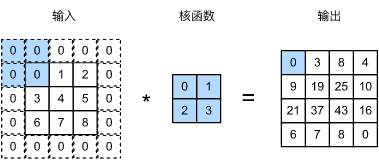

例如，在上图中中，我们将$3 \times 3$输入填充到$5 \times 5$，那么它的输出就增加为$4 \times 4$。阴影部分是第一个输出元素以及用于输出计算的输入和核张量元素：
$0\times0+0\times1+0\times2+0\times3=0$。

通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$$

这意味着输出的高度和宽度将分别增加$p_h$和$p_w$。

## 补齐原则
在许多情况下，我们需要设置$p_h=k_h-1$和$p_w=k_w-1$，使输入和输出具有相同的高度和宽度。
这样可以在构建网络时更容易地预测每个图层的输出形状。假设$k_h$是奇数，我们将在高度的两侧填充$p_h/2$行。
如果$k_h$是偶数，则一种可能性是在输入顶部填充$\lceil p_h/2\rceil$行，在底部填充$\lfloor p_h/2\rfloor$行。同理，我们填充宽度的两侧。

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5或7。
选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

此外，使用奇数的核大小和填充大小也提供了书写上的便利。对于任何二维张量`X`，当满足：
1. 卷积核的大小是奇数；
2. 所有边的填充行数和列数相同；
3. 输出与输入具有相同高度和宽度
则可以得出：输出`Y[i, j]`是通过以输入`X[i, j]`为中心，与卷积核进行互相关计算得到的。

比如，在下面的例子中，我们创建一个高度和宽度为3的二维卷积层，并(**在所有侧边填充1个像素**)。给定高度和宽度为8的输入，则输出的高度和宽度也是8。

In [26]:
import torch
from torch import nn


# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)##首先将输入X的形状从(height, width)变为(1, 1, height, width)。这是因为PyTorch的卷积层要求输入是4维的,其中第一维表示批量大小,第二维表示通道数。
    Y = conv2d(X)##输入传入卷积层conv2d,得到输出张量Y。
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高度和宽度不同时，我们可以[**填充不同的高度和宽度**]，使输出和输入具有相同的高度和宽度。在如下示例中，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1。

In [27]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))##这里直接利用torch中的Conv2d方法进行补齐
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下、向右滑动。
在前面的例子中，我们默认每次滑动一个元素。
但是，有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

我们将每次滑动元素的数量称为*步幅*（stride）。那么如何使用较大的步幅呢？


通常，当垂直步幅为$s_h$、水平步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果我们设置了$p_h=k_h-1$和$p_w=k_w-1$，则输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。
更进一步，如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为$(n_h/s_h) \times (n_w/s_w)$。

下面，我们[**将高度和宽度的步幅设置为2**]，从而将输入的高度和宽度减半。

In [28]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [29]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

为了简洁起见，当输入高度和宽度两侧的填充数量分别为$p_h$和$p_w$时，我们称之为填充$(p_h, p_w)$。当$p_h = p_w = p$时，填充是$p$。同理，当高度和宽度上的步幅分别为$s_h$和$s_w$时，我们称之为步幅$(s_h, s_w)$。特别地，当$s_h = s_w = s$时，我们称步幅为$s$。默认情况下，填充为0，步幅为1。在实践中，我们很少使用不一致的步幅或填充，也就是说，我们通常有$p_h = p_w$和$s_h = s_w$。


# 池化Pooling

## Maximum Pooling和Average Pooling

与卷积层类似，Pooling层运算符由一个固定形状的窗口组成，该窗口根据其步幅大小在输入的所有区域上滑动，为固定形状窗口（有时称为*池化窗口*）遍历的每个位置计算一个输出。
然而，不同于卷积层中的输入与卷积核之间的互相关计算，池化层不包含参数。
相反，池运算是确定性的，我们通常计算池化窗口中所有元素的最大值或平均值。

在这两种情况下，与互相关运算符一样，池化窗口从输入张量的左上角开始，从左往右、从上往下的在输入张量内滑动。在池化窗口到达的每个位置，它计算该窗口中输入子张量的最大值或平均值。计算最大值或平均值是取决于使用了最大池化层层还是平均池化层层。



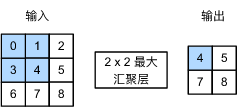

 图中的输出张量的高度为$2$，宽度为$2$。这四个元素为每个池化窗口中的最大值：

$$
\max(0, 1, 3, 4)=4,\\
\max(1, 2, 4, 5)=5,\\
\max(3, 4, 6, 7)=7,\\
\max(4, 5, 7, 8)=8.\\
$$

池化窗口形状为$p \times q$的池化层称为$p \times q$池化层，池化操作称为$p \times q$池化。

回到本节开头提到的对象边缘检测示例，现在我们将使用卷积层的输出作为$2\times 2$最大池化的输入。
设置卷积层输入为`X`，池化层输出为`Y`。
无论`X[i, j]`和`X[i, j + 1]`的值相同与否，或`X[i, j + 1]`和`X[i, j + 2]`的值相同与否，池化层始终输出`Y[i, j] = 1`。
也就是说，使用$2\times 2$最大池化层，即使在高度或宽度上移动一个元素，卷积层仍然可以识别到模式。


In [30]:
import torch
from torch import nn
from d2l import torch as d2l

In [32]:
def pool2d(X, pool_size, mode='max'):##pool_size: 池化窗口的大小,以元组(p_h, p_w)的形式给出
    p_h, p_w = pool_size##首先根据输入张量X的尺寸和池化窗口大小,计算输出张量Y的尺寸。
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))##输出张量的高度为X.shape[0] - p_h + 1,宽度为X.shape[1] - p_w + 1。这是因为池化窗口在输入张量上滑动时,每次移动1个单位。
    ##池化操作
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':##对于每个元素,根据池化模式('max'或'avg')从输入张量X的相应池化窗口中提取最大值或平均值,并赋值给Y[i, j]。
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [33]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [34]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## [**填充和步幅**]

与卷积层一样，池化层也可以改变输出形状。和以前一样，我们可以通过填充和步幅以获得所需的输出形状。
下面，我们用深度学习框架中内置的二维最大池化层，来演示池化层中填充和步幅的使用。
我们首先构造了一个输入张量`X`，它有四个维度，其中样本数和通道数都是1。


In [35]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，(**深度学习框架中的步幅与池化窗口的大小相同**)。
因此，如果我们使用形状为`(3, 3)`的池化窗口，那么默认情况下，我们得到的步幅形状为`(3, 3)`。


In [36]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [37]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

[**填充和步幅可以手动设定**]。

In [38]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

## 多个通道

在处理多通道输入数据时，[**池化层在每个输入通道上单独运算**]，而不是像卷积层一样在通道上对输入进行汇总。
这意味着池化层的输出通道数与输入通道数相同。
下面，我们将在通道维度上连结张量`X`和`X + 1`，以构建具有2个通道的输入。

In [40]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

如下所示，汇聚后输出通道的数量仍然是2。

In [42]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])